In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

from sklearn.linear_model import LinearRegression
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


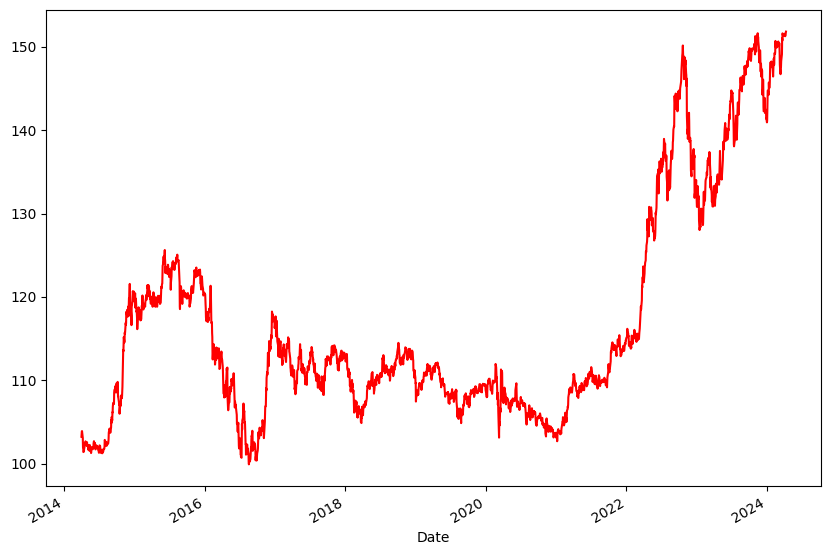

Linear Regression model
JPY=X Price (y) = 1.22 * 3 Days Moving Average (x1)     + -0.23 * 9 Days Moving Average (x2)     + 0.88 (constant)


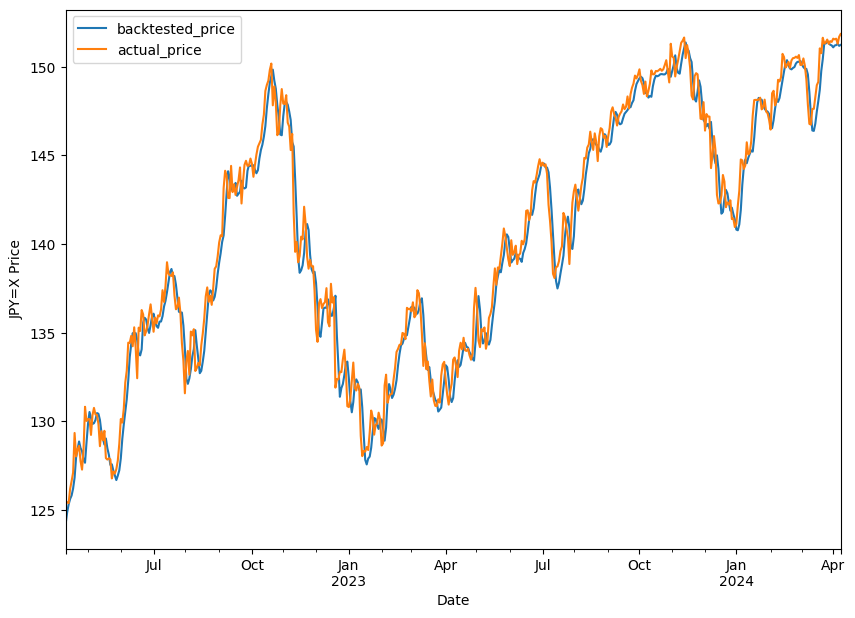

[*********************100%%**********************]  1 of 1 completed


                 Close         S_3         S_9
Date                                          
2014-04-11  101.379997  101.814000  102.937889
2014-04-14  101.442001  101.643000  102.741001
2014-04-15  101.903999  101.575333  102.548889
2014-04-16  101.876999  101.741000  102.327778
2014-04-17  102.200996  101.993998  102.139444
...                ...         ...         ...
2024-04-03  151.539993  151.506327  151.454108
2024-04-04  151.580994  151.567327  151.448330
2024-04-05  151.292007  151.470998  151.446888
2024-04-08  151.690002  151.521001  151.482110
2024-04-09  151.843002  151.608337  151.516888

[2605 rows x 3 columns]


[*********************100%%**********************]  1 of 1 completed


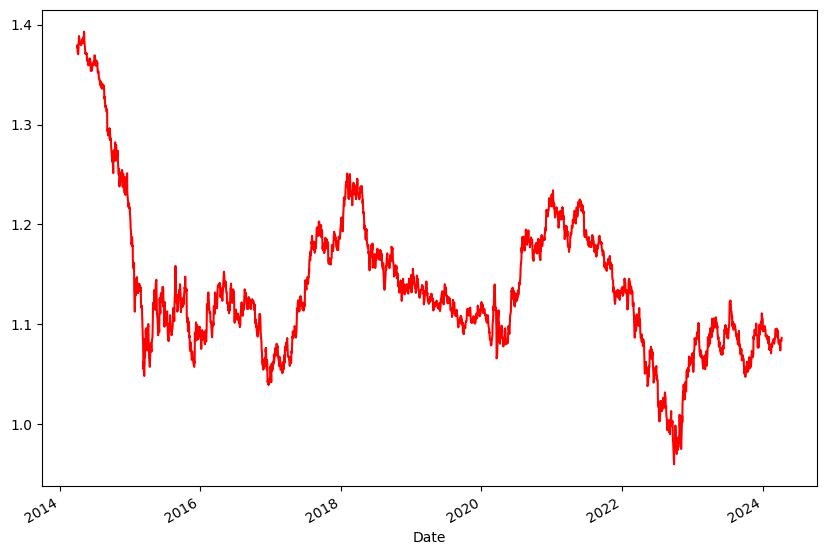

Linear Regression model
EURUSD=X Price (y) = 1.18 * 3 Days Moving Average (x1)     + -0.19 * 9 Days Moving Average (x2)     + 0.01 (constant)


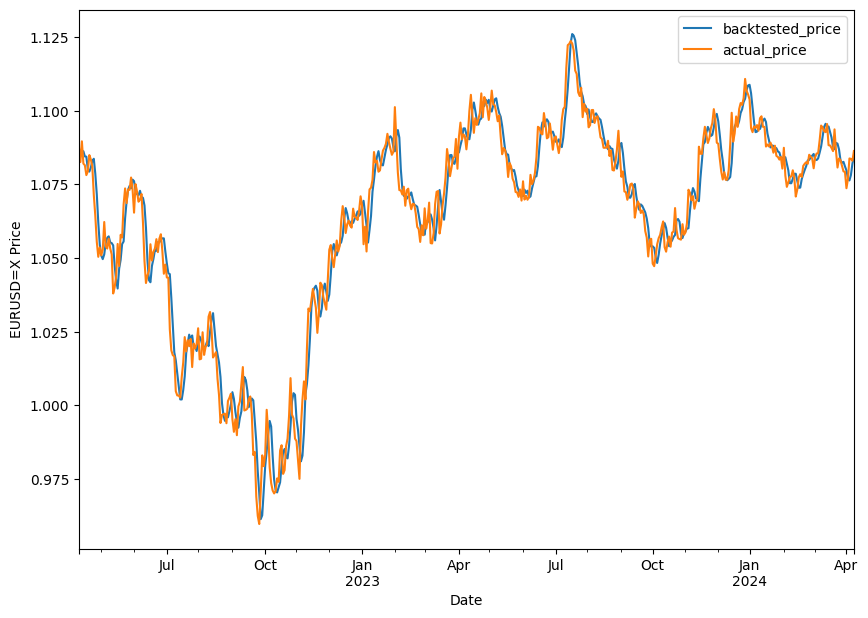

[*********************100%%**********************]  1 of 1 completed


               Close       S_3       S_9
Date                                    
2014-04-11  1.388638  1.384490  1.378264
2014-04-14  1.384620  1.386253  1.379054
2014-04-15  1.381712  1.384990  1.379302
2014-04-16  1.381196  1.382509  1.379788
2014-04-17  1.382705  1.381871  1.380935
...              ...       ...       ...
2024-04-03  1.076855  1.076617  1.080520
2024-04-04  1.083835  1.078137  1.080254
2024-04-05  1.083705  1.081465  1.080582
2024-04-08  1.083048  1.083529  1.080495
2024-04-09  1.086366  1.084373  1.080843

[2605 rows x 3 columns]


In [3]:
products = ['JPY=X','EURUSD=X']

for product in products:
    df = yf.download(product, '2014-04-01', '2024-04-10') # 10 years
    df = df[['Close']]

    # only keep closing price
    df = df.dropna()
    df.Close.plot(figsize=(10, 7),color='r')
    plt.show()
    
    # train: use moving averages over last 3 days and 9 days 
    df['S_3'] = df['Close'].rolling(window=3).mean()
    df['S_9'] = df['Close'].rolling(window=9).mean()
    df['next_day_price'] = df['Close'].shift(-1)

    df = df.dropna()
    x = df[['S_3', 'S_9']]

    y = df['next_day_price']

    # separate testing and training data
    index = int(0.8*(len(df)))
    x_train, x_test, y_train, y_test = x[:index], x[index:], y[:index], y[index:]

    # train linear regression
    linear = LinearRegression().fit(x_train, y_train)

    print("Linear Regression model")
    print(f"{product} Price (y) = %.2f * 3 Days Moving Average (x1) \
    + %.2f * 9 Days Moving Average (x2) \
    + %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))
    
    # backtest
    backtest_price = linear.predict(x_test)
    backtest_price = pd.DataFrame(
        backtest_price, index=y_test.index, columns=['price'])
    backtest_price.plot(figsize=(10, 7))
    y_test.plot()
    plt.legend(['backtested_price', 'actual_price'])
    plt.ylabel(f"{product} Price")
    plt.show()

    # export to excel
    export_df = pd.DataFrame({
        'dates': x_test.index, 
        'Historical Price': y_test,
        'Model Predicted Price': backtest_price['price']  
    })

    # Export the DataFrame to an Excel file
    export_df.to_excel(f"{product}_backtest_results.xlsx", index=False)
    
    # predict next 3 months
    predict_df = yf.download(product, '2014-04-01', '2024-04-10') # 10 years
    predict_df = predict_df[['Close']]
    predict_df = predict_df[['Close']]
    predict_df = predict_df.dropna()
    predict_df['S_3'] = predict_df['Close'].rolling(window=3).mean()
    predict_df['S_9'] = predict_df['Close'].rolling(window=9).mean()
    predict_df = predict_df.dropna()
    print(predict_df)
    current_date = predict_df.index[-1]
    end_date = datetime(2024, 7, 31)

    while current_date <= end_date:
        # forecast the price
        predict_df['predicted_price'] = linear.predict(predict_df[['S_3', 'S_9']])
        last_row = predict_df.tail(1)
        predicted_price = last_row['predicted_price'].iloc[-1]

        last_date = predict_df.index[-1]
        new_date = last_date + timedelta(days=1)
        current_date = new_date
        new_row = pd.DataFrame(index=[new_date], columns=predict_df.columns)
        new_row['Close'] = predicted_price
        moving_avg_list = predict_df['Close'].iloc[-8:].tolist()
        moving_avg_list.append(predicted_price)
        new_row['S_3'] = sum(moving_avg_list[-3:]) / 3
        new_row['S_9'] = sum(moving_avg_list) / 9
        warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")
        predict_df = pd.concat([predict_df, new_row])   
        # print("after adding new row")
        # print(df)

    # adjust to only weekly data 
    predict_df = predict_df.resample('W-FRI').last() # only weekly data 
    # export to excel
    export_df = pd.DataFrame({
        'Dates': predict_df.index, 
        'Historical Price': predict_df['Close'], 
        'Base': predict_df['predicted_price'],
    })

    # Export the DataFrame to an Excel file
    export_df.to_excel(f"{product}_predicted_results.xlsx", index=False)